<p align="center">
  <a href="https://github.com/SimonBlanke/Hyperactive"><img src="./images/logo.png" width="500px"></a>
</p>

<br>
<br>

<font size="4">

# Tutorial for Hyperactive (v4)
    
    
This is a tutorial to introduce you to the basic functionalities of Hyperactive and provide some interesting applications. It will also give an introduction to some optimization techniques. Hyperactive is a package that can optimize any python function and collect its search data. 

### [You can learn more about Hyperactive on Github](https://github.com/SimonBlanke/Hyperactive)
 
## Table of contents:
* [Introduction](#intro)
    
* Optimization basics:
    * [Convex Optimization](#convex)
    * [Non-convex Optimization](#non_convex)
    
* Advanced Usage:
    * [Hyperactive memory](#memory)
    * [Machine Learning Optimization](#machine_learning)
    * [Continuing the search](#continuing-search)
    * [Parallel Computing](#parallel-comp)
    * [Data collection](#data_collect)
    * [Multiple objectives](#multi_objectives)
    * [Non-numerical search space](#search_space)
    * [Deep Learning Optimization](#deep_learning)
    


<font size="5">

This tutorial is made for version 4 of Hyperactive

In [31]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import time
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF, ConstantKernel

from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_wine, load_iris

from hyperactive import Hyperactive
from hyperactive.optimizers import BayesianOptimizer, HillClimbingOptimizer
from surfaces.visualize import plotly_surface, plotly_heatmap

color_scale = px.colors.sequential.Jet

In [5]:
def _create_grid(objective_function, search_space):
    def objective_function_np(*args):
        para = {}
        for arg, key in zip(args, search_space.keys()):
            para[key] = arg

        return objective_function(para)

    (x_all, y_all) = search_space.values()
    xi, yi = np.meshgrid(x_all, y_all)
    zi = objective_function_np(xi, yi)

    return xi, yi, zi

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def compare_objective_functions(objective_function1, objective_function2):
    search_space_plot = {
        "x": list(np.arange(-5, 5, 0.2)),
        "y": list(np.arange(-5, 5, 0.2)),
    }

    xi_c, yi_c, zi_c = _create_grid(objective_function1, search_space_plot)
    xi_a, yi_a, zi_a = _create_grid(objective_function2, search_space_plot)

    fig1 = go.Surface(x=xi_c, y=yi_c, z=zi_c, colorscale=color_scale)
    fig2 = go.Surface(x=xi_a, y=yi_a, z=zi_a, colorscale=color_scale)

    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=['Convex Function', 'Non-convex Function'],
                        )

    fig.add_trace(fig1, 1, 1)
    fig.add_trace(fig2, 1, 2)
    fig.update_layout(title_text="Objective Function Surface")
    fig.show()

In [6]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_width = 28
img_height = 28

x_train = x_train.astype("float32")
x_train /= 255.0
x_test = x_test.astype("float32")
x_test /= 255.0

# reshape input data
x_train = x_train.reshape(x_train.shape[0], img_width, img_height, 1)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height, 1)

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]


data = load_wine()
X_boston, y_boston = data.data, data.target

data = load_iris()
X_iris, y_iris = data.data, data.target

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<font size="4">
    
## Introduction <a class="anchor" id="intro"></a>
    
There are two things you need to define before starting your first optimization run:
    
    - the objective function: 
        Contains some kind of model. It always returns a score that will be maximized during
    - a search space: 
        Defines the parameter space in which the optimizer searches for the best parameter set
    
In this notebook you will see several different examples for objective functions. 
    

In [7]:
def objective_function(para):
    loss = para["x"]*para["x"]
    # -x*x is an inverted parabola 
    return -loss

# We have only one dimension here
search_space = {
    "x": list(np.arange(-5, 5, 0.01)),
}

<font size="4">

In the next step we will start the optimization run.

You only need the objective_function, search_space and the number of iterations. Each iteration will evaluate the objective function. This will generate a score, that the optimization algorithm uses to determine which position in the search space to look next. All of the calculations will be done by Hyperactive in the background. You will receive the results of the optimization run when all iterations are done.

In [8]:
hyper_0 = Hyperactive(verbosity=False)
hyper_0.add_search(objective_function, search_space, n_iter=70, initialize={"random": 2, "vertices": 2})
hyper_0.run()

search_data_0 = hyper_0.search_data(objective_function)
search_data_0[["x", "score"]]

x    score
0  -0.30  -0.0900
1  -4.83 -23.3289
2   4.99 -24.9001
3  -5.00 -25.0000
4  -3.09  -9.5481
..   ...      ...
65 -4.99 -24.9001
66 -1.21  -1.4641
67 -3.18 -10.1124
68  3.09  -9.5481
69  3.06  -9.3636

[70 rows x 2 columns]

<font size="4">

In the table above you can see the 70 iterations performed during the run. This is called the **search data**. In each row you can see the parameter ```x``` and the corresponding score. As we previously discussed the optimization algorithm determines which position to select next based on the score from the evaluated objective function. 

When Hyperactive starts the optimization the **first iterations are initializations** from the ```initialize```-dictionary. In the example above there are 4 initializations (2 random and 2 vertices). They determine the initial positions in the search space that are used to evaluate the objective funtion. As you can see in the search data the 2. and 3. iteration are the vertices (edge points) of the search space. The 0. and 1.
The first rows of the search data are randomly selected. After those few initialization steps the optimization algorithm will select the next positions in the search space based on the score of the previous position(s).
    
The default algorithm for the optimization is the **random-search**. You can see the random pattern in the last few iterations of the search data. We can also see the random pattern if we plot the search data:

<font size="4">

### Random Search Optimizer
    
The random search optimizer is a very simple algorithm. It randomly selects the position in each iteration without adapting to the optimization problem (exploitation). One the other hand it is very useful to initialy explore the search space or find new regions with optima (exploration).
    
The following two gifs show how random search explores the search space for two different objective functions:

<table><tr>
<td> <img src="./images/random_convex.gif"/> </td>
<td> <img src="./images/random_nonconvex.gif"/> </td>
</tr></table>

In [9]:
fig = px.scatter(search_data_0, x="x", y="score")
fig.show()

<font size="4">
    
The plot above shows the score of each parameter set (in this case just one parameter "x"). The random search explores the search space very well, so that we can see the inverse parabola.

<font size="4">
    
## Objective Functions <a class="anchor" id="convex"></a>
    
The shape of the objective function in the search space is a very important part of the optimization problem, because it heavily impacts the behaviour of the algorithm. Each optimization algorithm is well equiped to solve some kind of objective functions and perform poorly for others. 
    
A basic classifications of optimization problems is into convex- and nonconvex-problems. Convex optimization problems have a shape, where the score improves continuously as the position gets closer to the global optimum. So it does not have any local optima in its shape. Nonconvex-problems do have these local optima.

<font size="4">
    
### Convex Optimization <a class="anchor" id="convex"></a>
    
Lets take a closer look at the convex optimization problem and try out different optimization algorithms:

In [10]:
def convex_function(para):
    loss = (para["x"]*para["x"] + para["y"]*para["y"])
    return -loss


search_space = {
    "x": list(np.arange(-5, 5, 0.01)),
    "y": list(np.arange(-5, 5, 0.01)),
}

In [11]:
hyper_convex_0 = Hyperactive(verbosity=False)
hyper_convex_0.add_search(convex_function, search_space, n_iter=2000)
hyper_convex_0.run()

In [12]:
search_data_convex_0 = hyper_convex_0.search_data(convex_function)

In [13]:
fig = px.scatter(search_data_convex_0, x="x", y="y", color="score", color_continuous_scale=color_scale)
fig.update_layout(width=900, height=800, xaxis_range=[-5, 5], yaxis_range=[-5, 5])
fig.show()

<font size="4">
    
The plot above shows the samples from the search data acquired from the convex-function in a 2-dimensional search space. The score is shown by the color of each point in the scatter plot. 

<font size="4">

We were able to see, that random search is a good optimization technique to explore the search space. But the goal is often to quickly find position in the search space with a high score. Therefore we should consider other optimization techniques like the hill climbing algorithm.

<font size="4">

### Hill Climbing Optimizer
    
The hill climbing optimization algorithm works by finding a random neighbour position close to the current position. If the score of the new position is better than the current one the algorithm makes a step to the new position and returns to finding the next position. This behaviour is like someone who tries to find the highest (highest score) position in a space by only moving up and never moves down. 
    
The hill climbing algorithm works very well with convex optimization problems, because the score continuously improves towards a direction. Hill climbing can find this direction by exploring the scores of its neighbours.
Hill climbing does not work of there are local optima. It tends to get "stuck" in certain regions, where the current position is surrounded by positions with worse scores. The algorithm would need to first "go down" and later "go up" again to find other (even better) positions in the search space.


<table><tr>
<td> <img src="./images/hill_climbing_convex.gif"/> </td>
<td> <img src="./images/hill_climbing_nonconvex.gif"/> </td>
</tr></table>

In [14]:
optimizer = HillClimbingOptimizer(rand_rest_p=0)

hyper_convex_1 = Hyperactive(verbosity=False)
hyper_convex_1.add_search(convex_function, search_space, n_iter=90, optimizer=optimizer, initialize={"vertices":1})
hyper_convex_1.run()

search_data_convex_1 = hyper_convex_1.search_data(convex_function)

In [15]:
fig = px.scatter(search_data_convex_1, x="x", y="y", color="score", color_continuous_scale=color_scale)
fig.update_layout(width=900, height=800, xaxis_range=[-5, 5], yaxis_range=[-5, 5])
fig.show()

<font size="4">
    
The 2D-scatter plot above shows that the hill climbing algorithm convertes quickly to the optimum of the objective function in the search space. Hill climbing is specialized to find the optimum of convex functions quickly. It was able to find a good score in less than 100 iterations, while the random search used much more for a similar maximum score. 

<font size="4">
    
## Non-convex Optimization <a class="anchor" id="non_convex"></a>
    
Next we explore the performance of different optimization algorithms on the ackley-function, which is a nonconvex objective function:

In [16]:
def ackley_function(para):
    x, y = para["x"], para["y"]

    loss = (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x * x + y * y)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.exp(1)
        + 20
    )

    return -loss


search_space = {
    "x": list(np.arange(-5, 5, 0.01)),
    "y": list(np.arange(-5, 5, 0.01)),
}

<font size="4">

The ackley function is a non convex function that has a lot of local optima. This is because of the cos-terms that create wave-like patterns in both dimensions.
    
In the following 3D-surface plots you can see an example for the sphere-function and ackley-function. Both plots are interactive, so you can take a closer look at the shape of those objective functions:

In [17]:
compare_objective_functions(convex_function, ackley_function)

In [18]:
hyper_ackley_0 = Hyperactive(verbosity=False)
hyper_ackley_0.add_search(ackley_function, search_space, n_iter=2000)
hyper_ackley_0.run()

search_data_ackley_0 = hyper_ackley_0.search_data(ackley_function)

In [19]:
fig = px.scatter(search_data_ackley_0, x="x", y="y", color="score", color_continuous_scale=color_scale)
fig.update_layout(width=900, height=800)
fig.show()

<font size="4">

The plot above shows the random search exploring the ackley function. Random search is not affected by the many local optima in the search space. Lets try out the hill climbing algorithm on the ackley function and see the results.

In [20]:
optimizer = HillClimbingOptimizer(rand_rest_p=0)

hyper_ackley_1 = Hyperactive(verbosity=False)
hyper_ackley_1.add_search(ackley_function, 
                          search_space, 
                          n_iter=100, 
                          optimizer=optimizer, 
                          initialize={"vertices": 1})
hyper_ackley_1.run()

search_data_ackley_1 = hyper_ackley_1.search_data(ackley_function)

In [21]:
fig = px.scatter(search_data_ackley_1, x="x", y="y", color="score", color_continuous_scale=color_scale)
fig.update_layout(width=900, height=800, xaxis_range=[-5, 5], yaxis_range=[-5, 5])
fig.show()

<font size="4">

Maybe you already expected, that the hill climbing algorithm delivers bad results optimizing the ackley function. That does not mean, that hill climbing is a bad algorithm in general. It means that it is bad for this kind of objective functions. This is a very important idea in mathematical optimization. It is very useful to know about the properties of the objective function, because you can choose an optimization algorithm that works really well for this problem.

<font size="4">
    
### Repulsing Hill Climbing Optimizer
    
The repulsing hill climbing optimizer tries to improve how hill climbing solves non-convex objective functions. It does so by increasing the radius in which hill climbing selects a neighbour position if the last position wasn't an improvement over the current one. This means the hill climber will jump away from its current position of it does not find better position in its close environment.

<table><tr>
<td> <img src="./images/tabu_convex.gif"/> </td>
<td> <img src="./images/tabu_nonconvex.gif"/> </td>
</tr></table>

In [22]:
from hyperactive.optimizers import RepulsingHillClimbingOptimizer

optimizer = RepulsingHillClimbingOptimizer()

hyper_ackley_2 = Hyperactive(verbosity=False)
hyper_ackley_2.add_search(ackley_function, 
                          search_space, 
                          n_iter=100, 
                          optimizer=optimizer, 
                          initialize={"vertices": 1})
hyper_ackley_2.run()

search_data_ackley_2 = hyper_ackley_2.search_data(ackley_function)

In [23]:
fig = px.scatter(search_data_ackley_2, x="x", y="y", color="score", color_continuous_scale=color_scale)
fig.update_layout(width=900, height=800, xaxis_range=[-5, 5], yaxis_range=[-5, 5])
fig.show()

<font size="4">
    
The plot above shows how the repulsing hill climbing optimizer explored the search space of the ackley function. It does a much better job finding new optima in the space, while also exploring local regions.

<font size="4">
    
## Hyperactive memory <a class="anchor" id="memory"></a>
  
Some objective functions (especially with machein- or deep- learning models) can take a long time to evaluate, which slows down the optimization run. This means, that we want to avoid any unnecessary evaluation of the objective function. Unfortunately most optimization algorithms won't avoid positions in the search space that were already evaluated. For example:
    
    - Random Search, which could select a position it already selected before
    - Hill climbing stuck in an optimum
    - Particle swarms that converge on one position
    
The bottom line is, that optimization algorithms don't "remember" already explored positions and won't avoid them. But Hyperactive has a feature that solves this problem, by saving the position and score in a memory-dictionary. If a position is selected Hyperactive will look up if this position is already known. If it knows the position and score it won't reevaluate the objective function but extract the score, which saves time. This is very useful for computationally expensive objective functions.
    
You can even pass the search data from a previous optimization run into the ```memory_warm_start```-argument, so that the optimization run "remembers" the memory from the previous one.

In [24]:
def dtr_model(opt):
    dtr = DecisionTreeRegressor(
        max_depth=opt["max_depth"],
        min_samples_split=opt["min_samples_split"],
    )
    scores = cross_val_score(dtr, X_boston, y_boston, cv=5)

    return scores.mean()


search_space_dtr = {
    "max_depth": list(range(10, 35)),
    "min_samples_split": list(range(2, 35)),
}

In [25]:
c_time1 = time.time()

hyper_dtr_0 = Hyperactive(verbosity=False)
hyper_dtr_0.add_search(dtr_model, search_space_dtr, n_iter=300)
hyper_dtr_0.run()

d_time1 = time.time() - c_time1
print("Optimization time 1:", round(d_time1, 2))

# Hyperactive collects the search data
search_data_dtr_0 = hyper_dtr_0.search_data(dtr_model, times=True)

Optimization time 1: 1.31


<font size="4">

After the first optimization run we start an additional run and pass the search data into ```memory_warm_start```. We expect that the next run will be faster, because we already have explored 300 positions in the search space from the previous optimization run.

<font size="4">
    
    

<font size="4">
    


In [26]:
c_time2 = time.time()

hyper_dtr_1 = Hyperactive(verbosity=False)
hyper_dtr_1.add_search(dtr_model, search_space_dtr, n_iter=300, memory_warm_start=search_data_dtr_0)
hyper_dtr_1.run()

d_time2 = time.time() - c_time2
print("Optimization time 2:", round(d_time2, 2))

Optimization time 2: 0.84


In [27]:
print("\n The second optimization run is "+'{}'.format(round((1-d_time2/d_time1)*100,2))+"% faster than the first one.")


 The second optimization run is 35.86% faster than the first one.


In [32]:
search_data_dtr_1 = hyper_dtr_1.search_data(dtr_model, times=True)
search_data_dtr = pd.concat([search_data_dtr_1, search_data_dtr_0], ignore_index=True)

In [33]:
# times in seconds
eval_times = search_data_dtr_0["eval_times"]
eval_times_mem = search_data_dtr_1["eval_times"]

opt_times = search_data_dtr["iter_times"]-search_data_dtr["eval_times"]

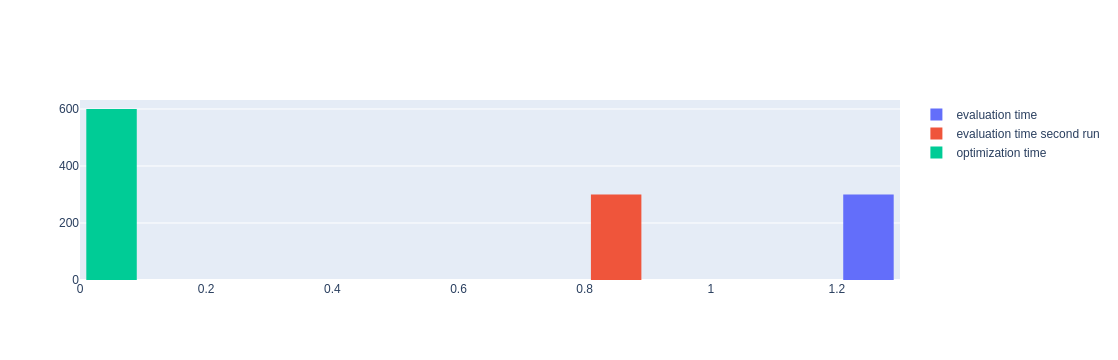

In [34]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=eval_times, name="evaluation time", nbinsx=15))
fig.add_trace(go.Histogram(x=eval_times_mem, name="evaluation time second run", nbinsx=15))
fig.add_trace(go.Histogram(x=opt_times, name="optimization time", nbinsx=15))
fig.show()

<font size="4">
    
The evaluation- and optimization- times from the two optimization runs is shown in the histogram above. There are several interesting things to see:
    
    - Even for simple machine learning models the optimization algorithm is much faster.
    - The evaluations, which are faster than the optimization are from the memory-dictionary lookup.
    - The second optimization run has much more memory lookups than the first.



<font size="4">
    
## Machine Learning Hyperparameter Optimization <a class="anchor" id="machine_learning"></a>

Until now we mostly optimized test functions to show how an objective function and the search space can look like. These problems were easy to solve, because the objective funtion evaluates very fast and the search space is very small. Real optimization problems often have one of those two problems:
    - The objective function is computationally expensive, so it takes a long time to evaluate. This increases the iteration time and slowes down the optimization progress.
    - The search space is very large. This can makes it very difficult to find positions with a high score.
    
In the first case you would want to use optimization algorithms that are very inteligent in finding new positions with high scores. You don't want to waste too much time exploring the search space, because each evaluation takes such a long time. You want to get to a good position with a high score in as few steps as possible.
    
In the second case you would want a fast algorithm, that looks for a good score but also explores the search space very well.

<font size="4">
    
Lets take a look at a (kind of) real optimization problem. We want to optimize the hyperparameters of a gradient boosting regressor that is trained on the boston housing regression dataset.

In [35]:
def gbr_model_0(opt):
    gbr = GradientBoostingRegressor(
        n_estimators=opt["n_estimators"],
        max_depth=opt["max_depth"],
    )
    scores = cross_val_score(gbr, X_boston, y_boston, cv=5)
    score = scores.mean()
    return score


search_space_gbr_0 = {
    "n_estimators": list(range(10, 100)),
    "max_depth": list(range(2, 12)),
}

In [36]:
hyper_gbr_0 = Hyperactive(verbosity=False)
hyper_gbr_0.add_search(gbr_model_0, search_space_gbr_0, n_iter=50)
hyper_gbr_0.run()

search_data_gbr_0 = hyper_gbr_0.search_data(gbr_model_0)

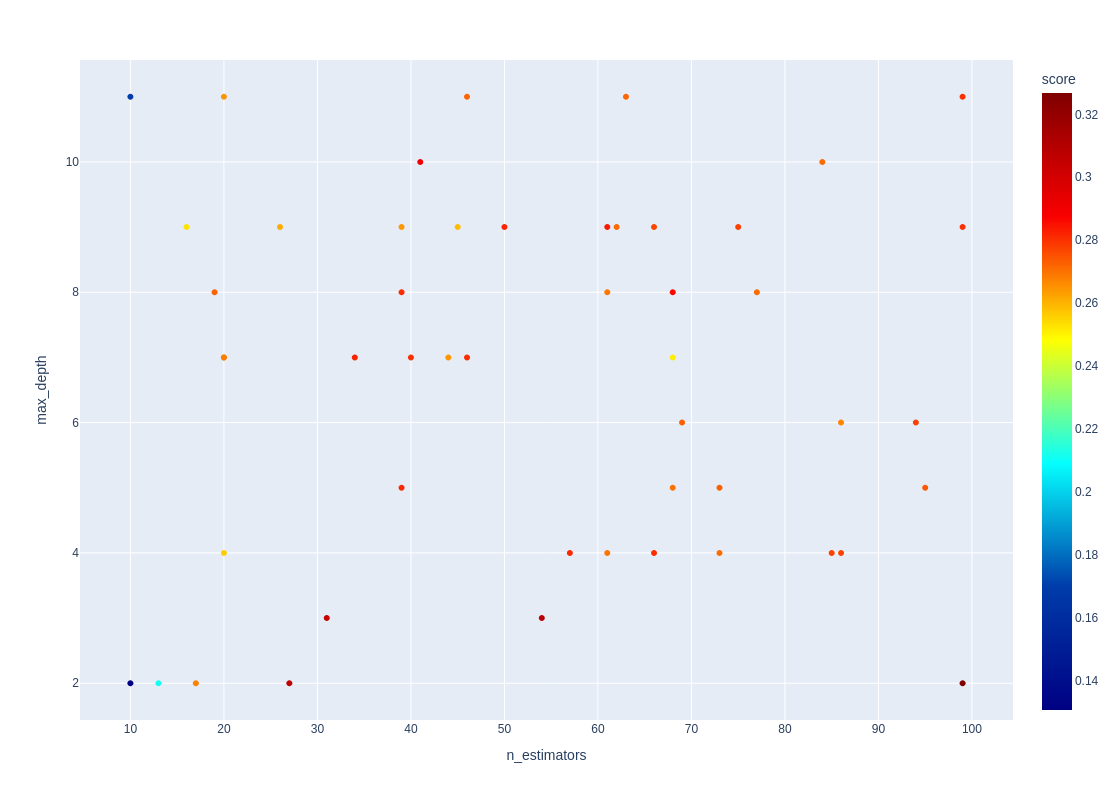

In [37]:
fig = px.scatter(search_data_gbr_0, 
                 x="n_estimators", 
                 y="max_depth", 
                 color="score", 
                 color_continuous_scale=color_scale)

fig.update_layout(width=900, height=800)
fig.show()

<font size="4">
    
The scatter plot above contains the samples from the search data from the gbr-model. It seams that high ```max_depth``` delivers bad scores but we should explore higher values for ```n_estimators```.

<font size="4">

## Continuing the Search <a class="anchor" id="continuing-search"></a>

<br>

Hyperactive makes it very easy to continue a search. The search data you already used for data exploration can just be passed to Hyperactive. This is done in multiple ways:
    
    - You can extract the best parameters via the "best_para"-method. This can than be passed to "initialize" to start at this position in the search space
    - The search data from the "results"-method can be passed to "memory_warm_start". The search data is automaticaly added into the memory-dictionary.
    - You can also pass the search data to "warm_start_smbo". This has the effect that the Bayesian optimizer can do more precise approximations in the beginning of the optimization run.
   

In [38]:
best_para_gbr_0 = hyper_gbr_0.best_para(gbr_model_0)
initialize = {"random": 4, "warm_start": [best_para_gbr_0]}


search_space_gbr_01 = {
    "n_estimators": list(range(10, 250, 5)),
    "max_depth": list(range(2, 8)),
}


hyper_gbr_01 = Hyperactive(verbosity=False)
hyper_gbr_01.add_search(gbr_model_0, 
                        search_space_gbr_01, 
                        n_iter=50,
                        n_jobs=2,
                        memory_warm_start=search_data_gbr_0, 
                        initialize=initialize)
hyper_gbr_01.run()

search_data_gbr_01 = hyper_gbr_01.search_data(gbr_model_0)

In [40]:
# merge the search data from the previous run and the current run
search_data_gbr_01_ = pd.concat([search_data_gbr_01, search_data_gbr_0], ignore_index=True)
search_data_gbr_01_

n_estimators  max_depth     score
0             115          5  0.284063
1             155          7  0.255712
2              60          7  0.278320
3              50          4  0.281999
4             100          2  0.326906
..            ...        ...       ...
145            94          6  0.277793
146            17          2  0.267768
147            77          8  0.271358
148            68          7  0.251152
149            86          6  0.267250

[150 rows x 3 columns]

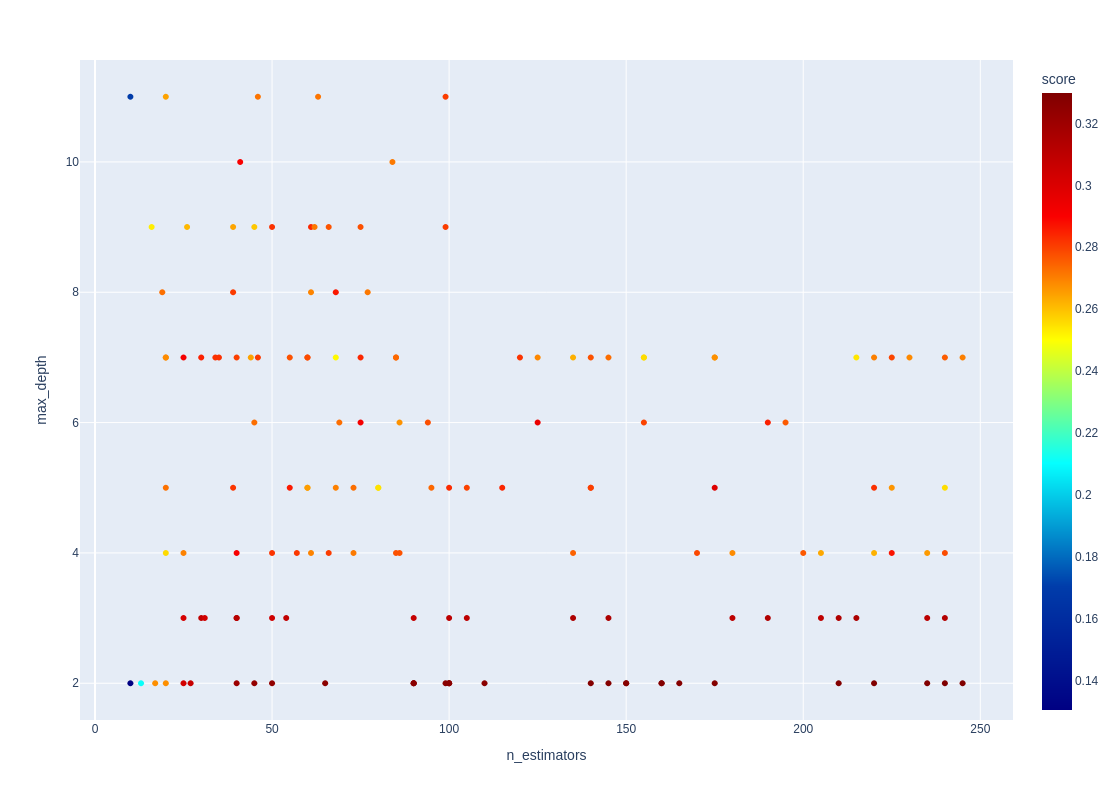

In [41]:
fig = px.scatter(search_data_gbr_01_, 
                 x="n_estimators", 
                 y="max_depth", 
                 color="score", 
                 color_continuous_scale=color_scale)

fig.update_layout(width=900, height=800)
fig.show()

<font size="4">

    
The scatter plot shows the search data from the previous run on the left side and the new search data on the bottom, because of the different search spaces. 

<font size="4">

## Parallel Computing <a class="anchor" id="parallel-comp"></a>




<font size="4">
    
Lets throw more computational resources at this problem:
    
    - 1 job does a hill climbing search starting at the best position from the last run
    - 1 job does a hill climbing search with four random initial positions
    - 2 jobs doing a random search
    
All of those jobs run in parallel and merge their results into one search data file.

In [42]:
best_para_gbr_01 = hyper_gbr_01.best_para(gbr_model_0)
initialize = {"warm_start": [best_para_gbr_01]}


search_space_gbr_02 = {
    "n_estimators": list(range(150, 300, 2)),
    "max_depth": list(range(2, 5)),
}

optimizer = HillClimbingOptimizer(rand_rest_p=0)

hyper_gbr_02 = Hyperactive(verbosity=False)
hyper_gbr_02.add_search(gbr_model_0, 
                        search_space_gbr_02, 
                        n_iter=50,
                        n_jobs=1,
                        optimizer=optimizer,
                        memory_warm_start=search_data_gbr_01_, 
                        initialize=initialize)
hyper_gbr_02.add_search(gbr_model_0, 
                        search_space_gbr_02, 
                        n_iter=50,
                        n_jobs=1,
                        optimizer=optimizer,
                        memory_warm_start=search_data_gbr_01_, 
                        initialize={"random": 4})
hyper_gbr_02.add_search(gbr_model_0, 
                        search_space_gbr_02, 
                        n_iter=50,
                        n_jobs=2,
                        memory_warm_start=search_data_gbr_01_)
hyper_gbr_02.run()

search_data_gbr_02 = hyper_gbr_02.search_data(gbr_model_0)

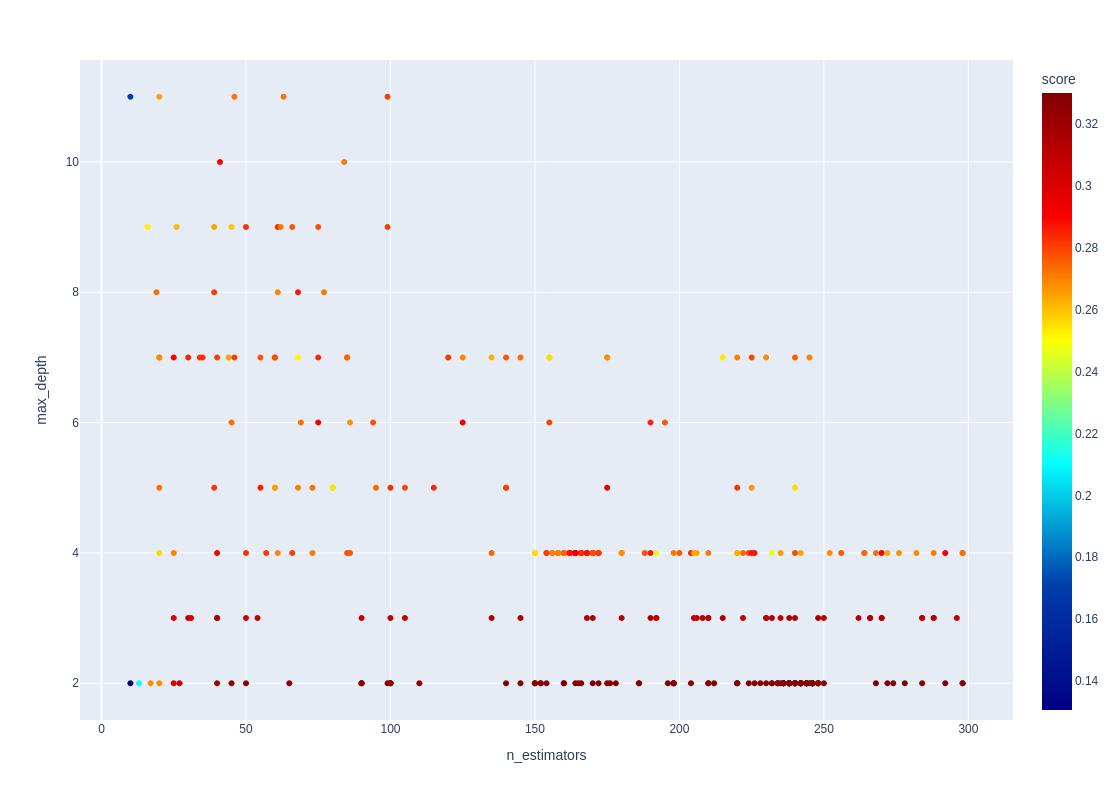

In [44]:
search_data_gbr_02_ = pd.concat([search_data_gbr_02, search_data_gbr_01_], ignore_index=True)

fig = px.scatter(search_data_gbr_02_, 
                 x="n_estimators", 
                 y="max_depth", 
                 color="score", 
                 color_continuous_scale=color_scale)

fig.update_layout(width=900, height=800)
fig.show()

<font size="4">

All the search data we collected shows a clear pattern. We should keep the ```max_depth``` at 2. In the following plot the search data is filtered to show only ```max_depth``` == 2, while showing the ```n_estimators``` dependend on the score.

In [45]:
search_data_gbr_02_f = search_data_gbr_02_[search_data_gbr_02_["score"] > 0.68]
search_data_gbr_02_f_max_depth2 = search_data_gbr_02_f[search_data_gbr_02_["max_depth"] == 2]

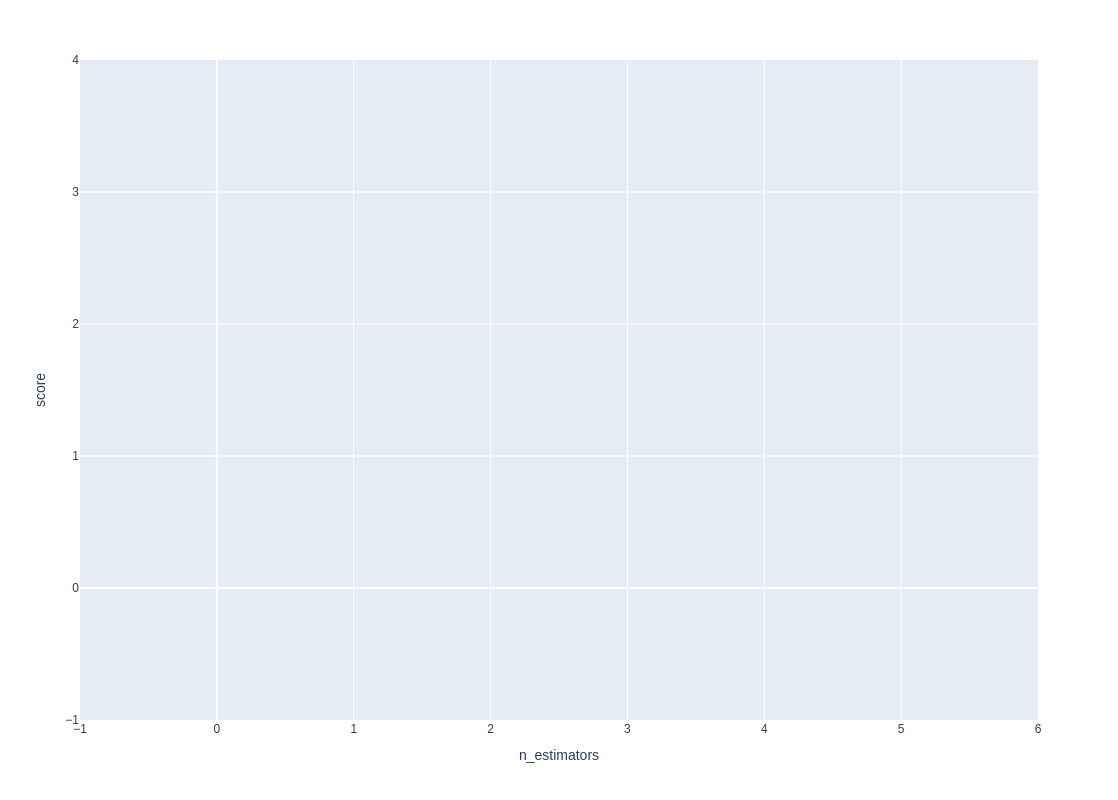

In [46]:
fig = px.scatter(search_data_gbr_02_f_max_depth2, 
                 x="n_estimators", 
                 y="score")

fig.update_layout(width=900, height=800)
fig.show()

<font size="4">

The filtering and visualization of the search data in the last few plots was an example how you can explore the model and search space yourself. Hyperactive makes it very easy to collect and reuse search data. Let's take a look how to collect more data:

<font size="4">
    
## Collecting more Data <a class="anchor" id="data_collect"></a>
    
Until now you have seen, that the objective function always returns only one variable: The score, which is always a real number. But Hyperactive has the capability to accept more variables. Those additional variables won't affect the score or the decision making of the optimization algorithm, but they will be collected in each iteration and accessed in the search data.
    
This feature can be very useful, because you can add any variable you want to the search data, which might help you understand the model better. To collect additional data in the objective function you just put it into a dictionary and return it alongside with the score. The key will be the column name in the search data and the value will be collected.

In [47]:
def gbr_model_1(opt):
    gbr = GradientBoostingRegressor(
        n_estimators=opt["n_estimators"],
        max_depth=opt["max_depth"],
    )
    c_time = time.time()
    scores = cross_val_score(gbr, X_boston, y_boston, cv=5)
    cv_time = time.time() - c_time
    
    # add the dictionary to collect more data
    return scores.mean(), {"cv_time": cv_time}


search_space_gbr_1 = {
    "n_estimators": list(range(10, 250, 5)),
    "max_depth": list(range(2, 8)),
}

In [48]:
hyper_gbr_1 = Hyperactive(verbosity=False)
hyper_gbr_1.add_search(gbr_model_1, search_space_gbr_1, n_iter=15, n_jobs=8, initialize={"random": 10})
hyper_gbr_1.run()

search_data_gbr_1 = hyper_gbr_1.search_data(gbr_model_1)
search_data_gbr_1.head()

n_estimators  max_depth   cv_time     score
0           115          5  0.287750  0.284063
1           155          7  0.372525  0.255712
2            60          7  0.151620  0.278320
3            50          4  0.129303  0.281999
4           220          2  0.430503  0.329662

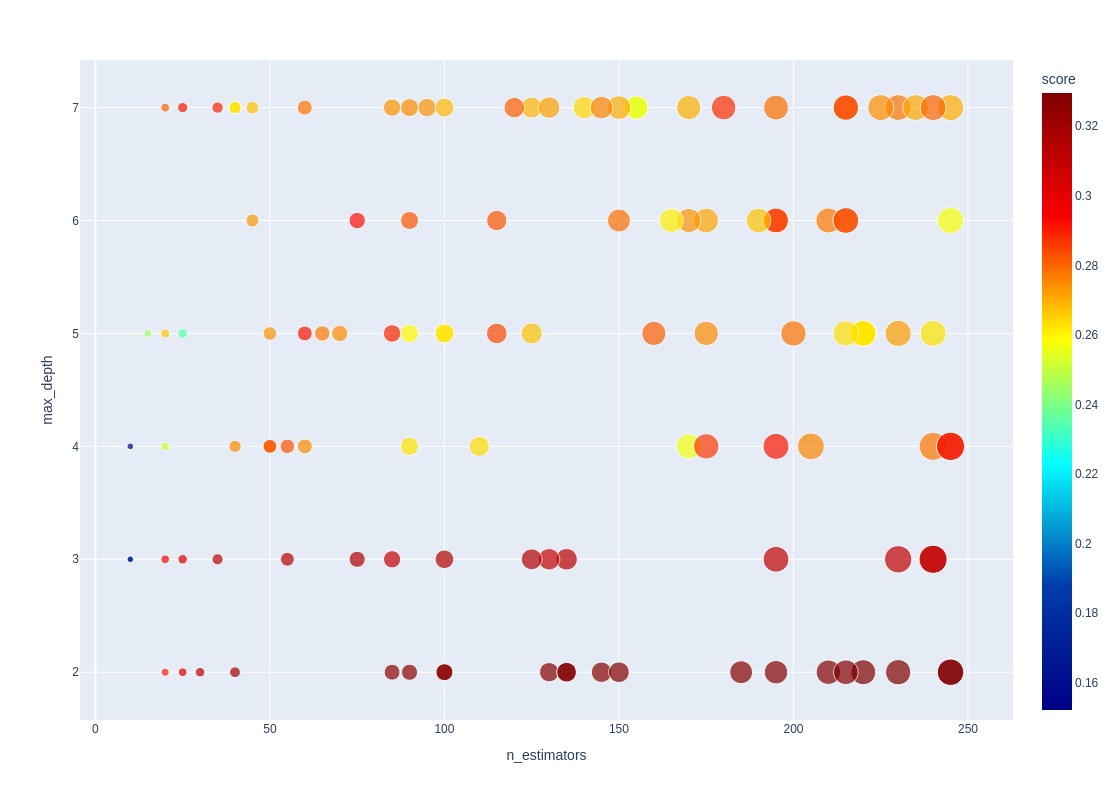

In [49]:
fig = px.scatter(search_data_gbr_1, 
                 x="n_estimators", 
                 y="max_depth", 
                 color="score", 
                 size='cv_time', 
                 color_continuous_scale=color_scale)

fig.update_layout(width=900, height=800)
fig.show()

<font size="4">
    
The scatter plot above shows the samples od the search data, but adds a visualization of the cross-validation-time with the size of the scatter-points.

<font size="4">
    
## Managing multiple objectives <a class="anchor" id="multi_objectives"></a>
    
In the last chapter you were able to collect additional data during the optimization run. This data did not affect the score. But you can still try to create one score that represents information from multiple scores. In the following example we want to optimize a model to get a high score and at the same time a low training time.

In [50]:
def gbr_model_2(opt):
    gbr = GradientBoostingRegressor(
        n_estimators=opt["n_estimators"],
        max_depth=opt["max_depth"],
    )
    c_time = time.time()
    scores = cross_val_score(gbr, X_boston, y_boston, cv=5)
    cv_time = time.time() - c_time
    
    score_cv_avg = scores.mean()
    score_cv_std = scores.std()
    
    # the score is calculated from the cv-score and the cv-training time
    score = score_cv_avg / (cv_time**0.1)
    
    # independed from the score we want some additional data
    return score, {"cv_time": cv_time, 
                   "score_cv_avg": score_cv_avg,
                   "score_cv_std": score_cv_std,
                  "scores": scores,
                  }


search_space_gbr_2 = {
    "n_estimators": list(range(10, 250, 5)),
    "max_depth": list(range(2, 12)),
}

<font size="4">
    
The objective function above enables us to return a score that is composed of multiple variables. At the same time, we also want to collect data about the variables the score is composed from. This helps us understand the score later during the data visualization.

In [51]:
hyper_gbr_2 = Hyperactive(verbosity=False)
hyper_gbr_2.add_search(gbr_model_2, search_space_gbr_2, n_iter=15, n_jobs=8, initialize={"random": 10})
hyper_gbr_2.run()

search_data_gbr_2 = hyper_gbr_2.search_data(gbr_model_2)
search_data_gbr_2.head()

n_estimators  max_depth   cv_time     score  score_cv_avg  score_cv_std  \
0           115          9  0.278767  0.323956      0.285109      0.350418   
1           155          4  0.384750  0.303924      0.276238      0.341092   
2           210          4  0.492086  0.299394      0.278899      0.343820   
3           115          3  0.269802  0.354206      0.310713      0.380707   
4            45         10  0.113186  0.348954      0.280639      0.345737   

                                              scores  
0  [0.0, 0.7591984186362237, 0.0, 0.6663448851761...  
1  [0.0, 0.7591973405896815, 0.0, 0.6219911592753...  
2  [0.0, 0.7591973311141902, 0.0, 0.6352967955975...  
3  [0.0, 0.7591984186362237, 0.0, 0.7943685944093...  
4  [0.0, 0.7606979573331243, 0.0, 0.6424959119937...

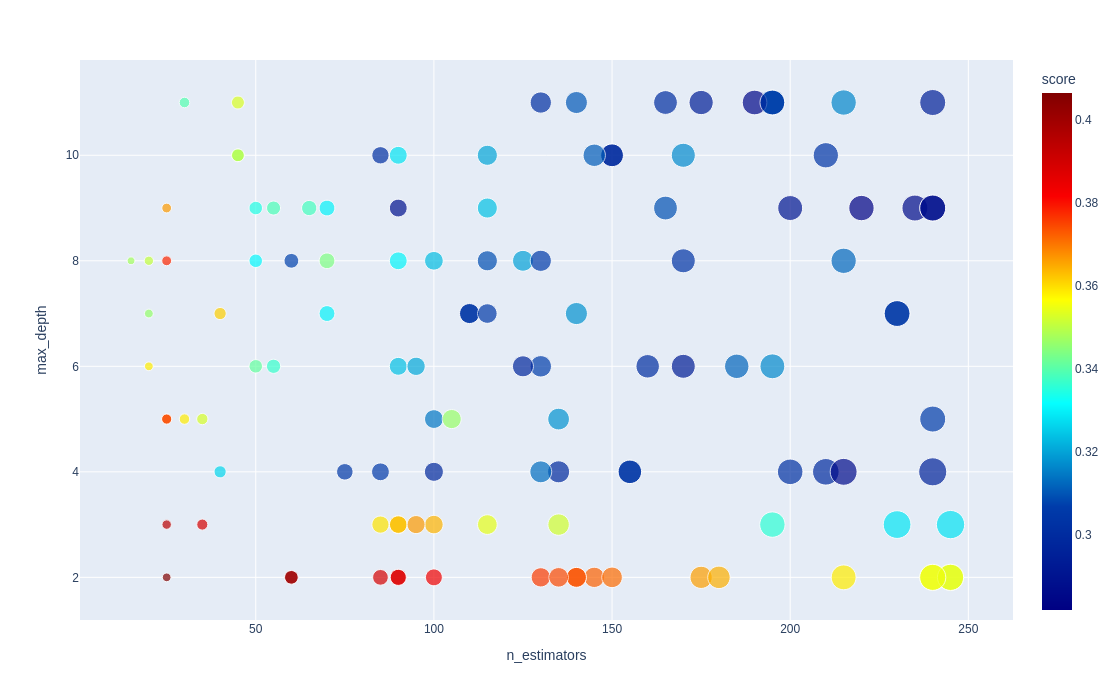

In [52]:
fig = px.scatter(search_data_gbr_2, 
                 x="n_estimators", 
                 y="max_depth", 
                 color="score", 
                 size='cv_time', 
                 color_continuous_scale=color_scale)

fig.update_layout(width=800, height=700)
fig.show()

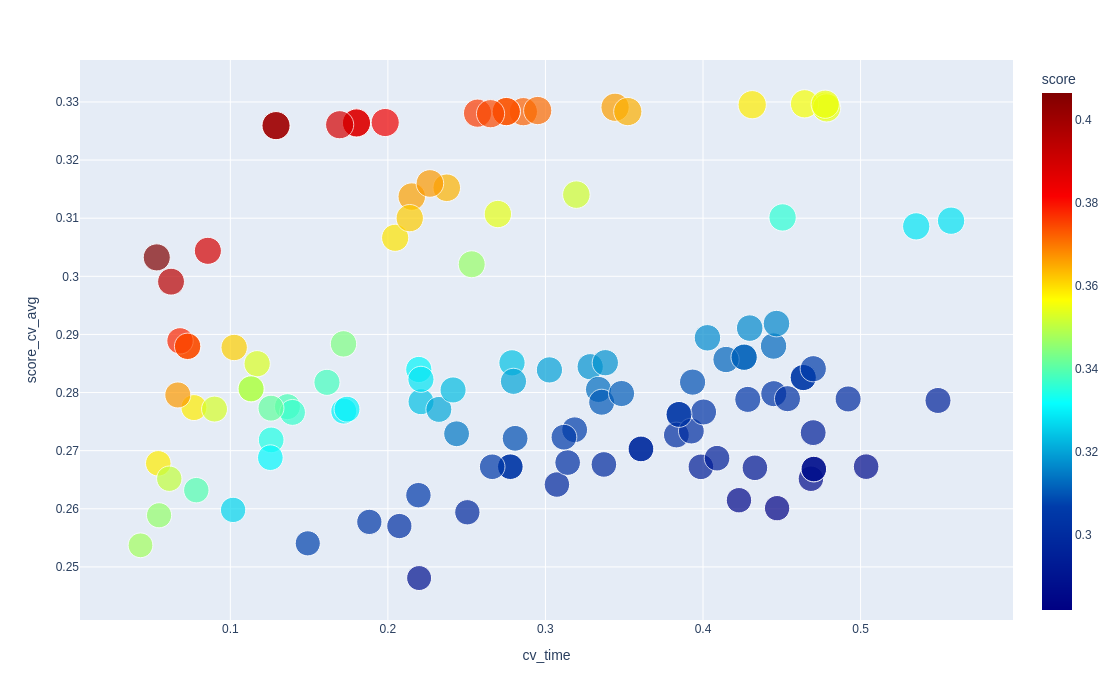

In [53]:
fig = px.scatter(search_data_gbr_2, 
                 x="cv_time", 
                 y="score_cv_avg", 
                 color="score", 
                 size='score_cv_std', 
                 color_continuous_scale=color_scale)

fig.update_layout(width=800, height=700)
fig.show()

<font size="4">
    
## Non-numerical Search Spaces <a class="anchor" id="search_space"></a>
    
This chapter describes a very unique and helpful feature of Hyperactive: non-numerical values in the search space. You are not constrained to use numeric values in your search space, but also strings or even functions. Because of this you can do some really interesting stuff like:
    
    - hyperparameter optimization of any parameter
    - preprocessing-optimization
    - neural architecture search
    
Lets take a look at the following example:

In [54]:
def mlp_model(opt): 
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X_iris)
    
    mlp = MLPClassifier(
        hidden_layer_sizes=opt["hidden_layer_sizes"],
        activation=opt["activation"],
        alpha=opt["alpha"],
        learning_rate_init=opt["learning_rate_init"],

    )
    scores = cross_val_score(mlp, X_norm, y_iris, cv=5)

    return scores.mean()


search_space_mlp = {
    "hidden_layer_sizes": list(range(10, 100, 10)),
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver":  ["lbfgs", "sgd", "adam"],
    "alpha": [1/(10**x) for x in range(1, 9)],
    "learning_rate_init": [1/(10**x) for x in range(1, 9)],

}

In [55]:
hyper_mlp_0 = Hyperactive(verbosity=False)
hyper_mlp_0.add_search(mlp_model, search_space_mlp, n_iter=40)
hyper_mlp_0.run()

mlp_search_data = hyper_mlp_0.search_data(mlp_model)
mlp_search_data.head()

hidden_layer_sizes activation solver         alpha  learning_rate_init  \
0                  60       relu    sgd  1.000000e-03            0.001000   
1                  60   identity  lbfgs  1.000000e-01            0.000001   
2                  50   logistic    sgd  1.000000e-04            0.000100   
3                  90   identity   adam  1.000000e-01            0.100000   
4                  90   identity  lbfgs  1.000000e-08            0.100000   

      score  
0  0.886667  
1  0.366667  
2  0.473333  
3  0.973333  
4  0.973333

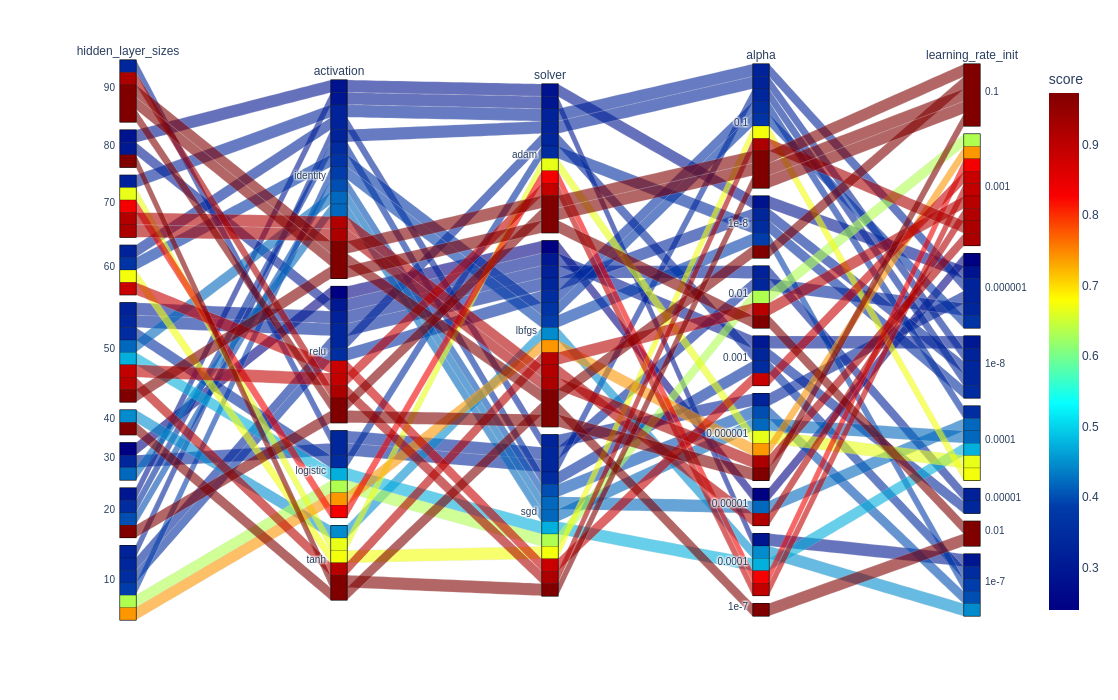

In [56]:
parameter_names = list(search_space_mlp.keys())

mlp_search_data = mlp_search_data.sort_values('hidden_layer_sizes', ascending=False)

fig = px.parallel_categories(mlp_search_data, 
                             color="score", 
                             color_continuous_scale=color_scale, 
                             dimensions=parameter_names, 
                             )
fig.update_layout(width=950, height=700)
fig.show()

<font size="4">
    
### Sequence Model-based Optimization

<br>

Sequence Model-based Optimization 


Bayesian optimization is a global optimization technique that uses a machine learning model (surrogate model) to approximate the objective function. It relies on a gaussian process regressor fitting to known positions and scores in the search space and predicting where to search next. It follows the following steps:
    
    - fit the gaussian process regressor to the training data (positions in search space) and the target (score of each position).
    - the regressor makes a prediction of every position in the search space
    - from the predictions an acquisition function is calculated that determines which position to evaluate next
    - after the evaluation the algorithm adds the position and score to the training data
    

Since the regressor is trained in every iteration the optimization step takes a long time compared to other algorithms. This is why it is often used for objective functions with a long evaluation time. The long optimization time does not matter if the evaluation time is even longer. In those cases it is much more important that each new position is carfully selected to avoid wasted time of an evaluation that has a low score.    

The following plots show an example of the path a bayesian optimization algorithm would take in different objective functions:

<table><tr>
<td> <img src="./images/bayes_convex.gif"/> </td>
<td> <img src="./images/bayes_nonconvex.gif"/> </td>
</tr></table>

In [ ]:
optimizer = BayesianOptimizer()

hyper_dl = Hyperactive(verbosity=False)
hyper_dl.add_search(deep_learning_model, search_space_dl, n_iter=30, optimizer=optimizer)
hyper_dl.run()

dl_search_data = hyper_dl.search_data(deep_learning_model, times=True)

In [ ]:
# we need to replace the functions with their names for the plot
def func2str(row):
    return row.__name__

dl_search_data["layer.0"] = dl_search_data["layer.0"].apply(func2str)
dl_search_data["layer.1"] = dl_search_data["layer.1"].apply(func2str)

dl_search_data = dl_search_data.drop(["eval_times", "iter_times"], axis=1)

In [ ]:
score_max = np.amax(search_data_0["score"])
score_std = search_data_0["score"].std()
dl_search_data_f = dl_search_data[abs(search_data_0["score"]-score_max) < score_std*2]

In [ ]:
dl_search_data

In [ ]:
parameter_names = list(dl_search_data_f.keys())

fig = px.parallel_categories(dl_search_data, 
                             color="score", 
                             color_continuous_scale=color_scale, 
                             dimensions=parameter_names, 
                             )
fig.update_layout(width=950, height=700)
fig.show()